In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 07: Redução de dimensionalidade

**1.** Considere o conjunto de dados disponível em penguins.csv, organizado em 5
colunas, sendo 4 colunas de atributos e a última a classe do padrão. Os dados
referem-se a medições anatômicas de pinguins da Antártida, classificados nas
espécies Adelie, Chinstrap e Gentoo. Maiores detalhes sobre os dados podem
ser conferidos em https://allisonhorst.github.io/palmerpenguins/.

Apresente a projeção em 2 dimensões dos padrões acima obtida pelo método PCA (análise dos componentes principais).

Ainda considerando o item anterior, calcule e mostre a variância explicada
obtida quando a dimensão projetada é modificada (1,2,3 ou 4).

Normalize os dados antes de executar PCA. Implemente sua própria versão de PCA, mas verifique a corretude comparando contra alguma implementação popular (e.g., da biblioteca scikitlearn).

Vamos iniciar dividindo os dados em features e labels:

In [274]:
penguins = pd.read_csv('penguins.csv',header=None)
penguins_label = penguins[4]
penguins = penguins.drop(columns=[4])

Normalizamos os dados (para que tenham média zero) e criamos uma matriz de covariância:

In [275]:
# feature standardization
penguins = (penguins - penguins.mean()) / penguins.std()

# cov matrix
cov_matrix = penguins.cov()

Como estamos realizando o PCA utilizando a eigen-decomposição da matriz de covariância, precisamos calcular os autovalores e autovetores da matriz de covariância e ordená-los em ordem decrescente:

In [276]:
# eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# sort eigenvalues and eigenvectors
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

Agora escolhemos os dois maiores autovalores e seus autovetores correspondentes para formar a matriz de projeção W.

In [277]:
# choose the two largest eigenvalues and their corresponding eigenvectors to form the projection matrix 
projection_matrix = eigenvectors[:,:2]

# project the data onto the new space
penguins_projected = penguins.dot(projection_matrix)

# concatenate the projected data with the labels
penguins_projected = pd.concat([penguins_projected, penguins_label], axis=1)

penguins_projected[4] = penguins_projected[4].astype('category')

E agora conseguimos fazer um plot dos dados projetados em 2 dimensões:

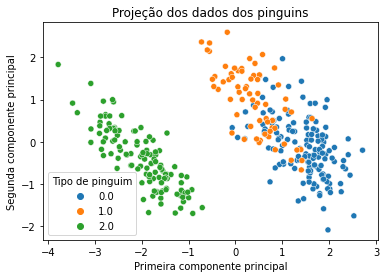

In [278]:
# plot the data using penguins_projected[4] as the color with legend
sns.scatterplot(x=0, y=1, hue=4, data=penguins_projected)
plt.legend(title='Tipo de pinguim')
plt.xlabel('Primeira componente principal')
plt.ylabel('Segunda componente principal')
plt.title('Projeção dos dados dos pinguins')
plt.show()

Vejamos agora a variância explicada para cada dimensão:

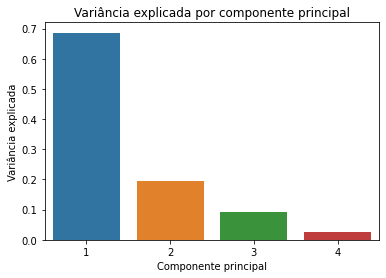

In [279]:
# get explained variance ratio
explained_variance_ratio = eigenvalues / eigenvalues.sum()
explained_variance_ratio

# plot the explained variance ratio where principal component is categorical
sns.barplot(x=[1,2,3,4], y=explained_variance_ratio)
plt.xlabel('Componente principal')
plt.ylabel('Variância explicada')
plt.title('Variância explicada por componente principal')
plt.show()

Por fim, desejamos comparar nossa performance com a implementação do PCA do scikit-learn. Para isso, utilizamos o mesmo conjunto de dados e comparamos os resultados:

Text(0.5, 1.0, 'Projeção dos dados dos pinguins')

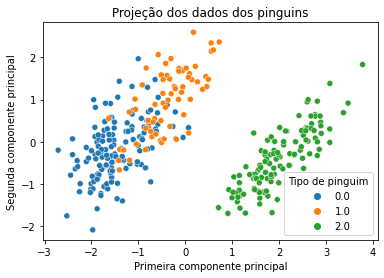

In [280]:
# use PCA from sklearn
pca = PCA(n_components=2)
penguins_projected = pca.fit_transform(penguins)

# concatenate the projected data with the labels
penguins_projected = pd.DataFrame(penguins_projected)
penguins_projected = pd.concat([penguins_projected, penguins_label], axis=1)
penguins_projected[4] = penguins_projected[4].astype('category')

# plot the data using penguins_projected[4] as the color with legend
sns.scatterplot(x=0, y=1, hue=4, data=penguins_projected)
plt.legend(title='Tipo de pinguim')
plt.xlabel('Primeira componente principal')
plt.ylabel('Segunda componente principal')
plt.title('Projeção dos dados dos pinguins')

Note que obtivemos a mesma projeção de dados, com a mesma distribuição de distâncias entre os pontos. Vejamos também a variância explicada:

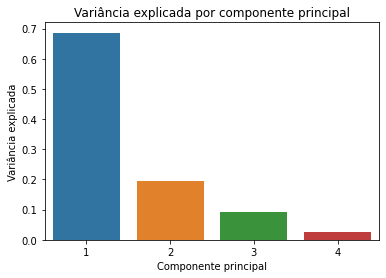

In [281]:
# get explained variance ratio for all four features of penguins
pca = PCA(n_components=4)
penguins_projected = pca.fit_transform(penguins)

# get explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# plot the explained variance ratio where principal component is categorical
sns.barplot(x=[1,2,3,4], y=explained_variance_ratio)
plt.xlabel('Componente principal')
plt.ylabel('Variância explicada')
plt.title('Variância explicada por componente principal')
plt.show()


Utilizando a implementação do scikit-learn, temos que usar um número de principal components igual a 4 para poder checar a variância explicada das 4 dimensões (se usássemos apenas 2, só veríamos a variância explicada para essas), mas note que obtivemos a mesma variância explicada para todas as dimensões, confirmando que nossa implementação está correta.

**2.** Implemente um autoencoder determinísitco para o banco de dados MNIST, que já usamos em exercícios anteriores. Você pode escolher utilizar tanto CNN como MLP no encoder/decoder. No entanto, o encoder deve mapear as imagens no $\mathbb{R}^2$, para podermos visualizar as representações latentes no plano. Use o conjunto de validação para fazer early stopping. Você também pode monitorar o erro na validação para anelar a taxa de aprendizado (usando um scheduler). Finalmente, mostre a projeção das imagens de teste no espaço latente e comente qualitativamente os embeddings obtidos.

Vamos começar importando carregando o dataset MNIST e dividindo em treino, validação e teste:

In [330]:
# import the data
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# split the data into train and validation
train_data, val_data = random_split(train_data, [0.8, 0.2])

# create dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

Vamos definir o encoder e o decoder, utilizando uma MLP simples:

In [294]:
# encoder with a MLP for MNIST

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# decoder with a MLP for MNIST
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 28*28)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

Agora definimos parâmetros de treinamento e treinamos o modelo, utilizando 10 epochs e passando por todas as batches, com batch size definido como 128:

In [295]:
loss = nn.MSELoss()
lr = 0.001
encoder = Encoder()
decoder = Decoder()

# optimizer
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)

# train the model
epochs = 10
for epoch in range(epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        x, _ = batch
        encoded = encoder(x)
        decoded = decoder(encoded)
        l = loss(decoded, x.view(-1, 28*28))
        l.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}, Loss: {l.item():.4f}')


Epoch: 1, Loss: 0.0494
Epoch: 2, Loss: 0.0414
Epoch: 3, Loss: 0.0416
Epoch: 4, Loss: 0.0422
Epoch: 5, Loss: 0.0432
Epoch: 6, Loss: 0.0389
Epoch: 7, Loss: 0.0419
Epoch: 8, Loss: 0.0383
Epoch: 9, Loss: 0.0385
Epoch: 10, Loss: 0.0385


Vamos verificar o funcionamento de nosso modelo checando inputs e suas respectivas reconstruções:

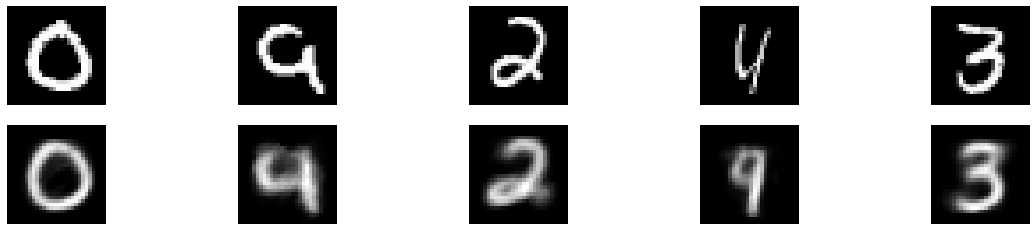

In [296]:
for batch in test_loader:
    x, _ = batch
    encoded = encoder(x)
    decoded = decoder(encoded)
    break

fig, ax = plt.subplots(2, 5, figsize=(20, 4))
for i in range(5):
    ax[0, i].imshow(x[i].view(28, 28), cmap='gray')
    ax[1, i].imshow(decoded[i].detach().view(28, 28), cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].axis('off')
plt.show()

É interessante observar que eles de fato batem com os inputs, e parecem reduções corretas. Agora vamos plotar a projeção das imagens de validação no espaço latente:

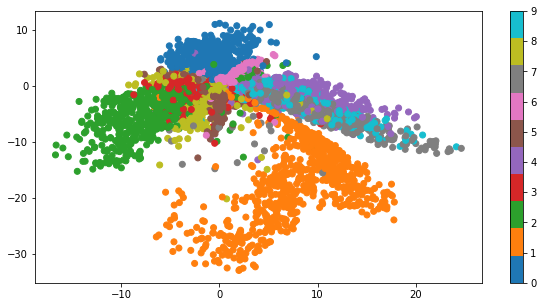

In [328]:
# get latent space for val_data
def plot_latent(data):
    for i, (x, y) in enumerate(data):
        encoded = encoder(x)
        plt.scatter(encoded.detach()[:, 0], encoded.detach()[:, 1], c=y, cmap='tab10')
        if i > 100:
            plt.colorbar()
            break

fig = plt.figure(figsize=(10, 5))
plot_latent(val_loader)

Note que as imagens com mesmo label, em geral, foram agrupadas na projeção bidimensional! Vamos utilizar o conjunto de validação para fazer early stopping:

In [331]:
# use validation for early stopping
def validate(data):
    total_loss = 0
    for x, y in data:
        encoded = encoder(x)
        decoded = decoder(encoded)
        l = loss(decoded, x.view(-1, 28*28))
        total_loss += l.item()
    return total_loss / len(data)

# train the model with early stopping  
epochs = 100
best_loss = 1000
for epoch in range(epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        x, _ = batch
        encoded = encoder(x)
        decoded = decoder(encoded)
        l = loss(decoded, x.view(-1, 28*28))
        l.backward()
        optimizer.step()
    val_loss = validate(val_loader)
    if val_loss < best_loss:
        best_loss = val_loss
    else:
        print(f'Epoch: {epoch+1}, Loss: {l.item():.4f}')
        break
    print(f'Epoch: {epoch+1}, Loss: {l.item():.4f}')

Epoch: 1, Loss: 0.0384
Epoch: 2, Loss: 0.0385
Epoch: 3, Loss: 0.0408
Epoch: 4, Loss: 0.0418
Epoch: 5, Loss: 0.0384
Epoch: 6, Loss: 0.0404
Epoch: 7, Loss: 0.0398


E, por fim, vamos plotar a projeção das imagens de teste no espaço latente:

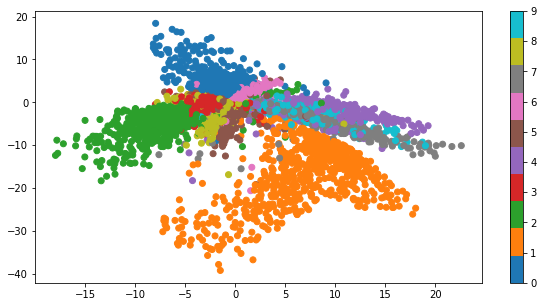

In [332]:
# plot the latent space for test_data

fig = plt.figure(figsize=(10, 5))
plot_latent(test_loader)

Para concluirmos, é importante observar que, realmente, as imagens com mesmo label foram agrupadas na projeção bidimensional, e que a projeção das imagens de teste no espaço latente foi feita corretamente. O embedding obtido é qualitativamente bom, e o modelo parece ter feito a representação latente de forma satisfatória.